# DDPG_Reacher

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [5]:
!pip -q install ./python

ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.24 which is incompatible.
tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.


The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [6]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
#env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

### 2. Examine the State and Action Spaces
In this environment, a double-jointed arm can move to target locations. A reward of +0.1 is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of 33 variables corresponding to position, rotation, velocity, and angular velocities of the arm. Each action is a vector with four numbers, corresponding to torque applicable to two joints. Every entry in the action vector must be a number between -1 and 1.

Run the code cell below to print some information about the environment.

In [7]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3. Take Random Actions in the Environment
In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step. A window should pop up that allows you to observe the agent, as it moves through the environment.

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [8]:
# env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
# states = env_info.vector_observations                  # get the current state (for each agent)
# scores = np.zeros(num_agents)                          # initialize the score (for each agent)
# while True:
#     actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
#     actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
#     env_info = env.step(actions)[brain_name]           # send all actions to tne environment
#     next_states = env_info.vector_observations         # get next state (for each agent)
#     rewards = env_info.rewards                         # get reward (for each agent)
#     dones = env_info.local_done                        # see if episode finished
#     scores += env_info.rewards                         # update the score (for each agent)
#     states = next_states                               # roll over states to next time step
#     if np.any(dones):                                  # exit loop if episode finished
#         break
# print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

### 4. It's Your Turn!
Now it's your turn to train your own agent to solve the environment! When training the environment, set train_mode=True, so that the line for resetting the environment looks like the following:

In [9]:
#env_info = env.reset(train_mode=True)[brain_name]

### Import

In [10]:
import os
import copy
import time
import json
import torch
import random
#from tqdm                  import tqdm
import torch.optim         as optim
import numpy               as np
import torch.nn            as nn
import matplotlib.pyplot   as plt
import torch.nn.functional as F
from collections           import namedtuple, deque
from unityagents           import UnityEnvironment
%matplotlib inline

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Model

The network is based on [the repository](https://github.com/udacity/deep-reinforcement-learning/blob/master/ddpg-pendulum/model.py) of Deep Reinforcement Learning on Udacity and [Lillicrap et al., 2015](https://arxiv.org/abs/1509.02971). The number of the input units is initialized from uniform distributions $[\frac{-1}{\sqrt{f}}, \frac{1}{\sqrt{f}}]$ where f is the fan-in of the layer.

In [12]:
def hidden_init(layer):
    # for initializing the hidden layer weights with random noise
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return -lim, lim

**The units of hidden layers**: The two hidden layers were initialzed with 400 and 300 units respectively ($\approx$ 130,000 parameters). The final layer weights and biases of both the actor and critic were initialized from a uniform distribution $[-3\times10^-3, 3\times10^-3]$. This was to ensure the initial outputs for the policy and the value estimates were near zero (Lillcrap et al., 2015) 

### Actor

In [13]:
class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=256, fc2_units=256):
        """Initialize parameters and build model.
        :param state_size: int. Dimension of each state
        :param action_size: int. Dimension of each action
        :param seed: int. Random seed
        :param fc1_units: int. Number of nodes in first hidden layer
        :param fc2_units: int. Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        # source: The low-dimensional networks had 2 hidden layers
        self.fc1 = nn.Linear(state_size, fc1_units)
        # applying a Batch Normalization on the first layer output
        self.bn1 = nn.BatchNorm1d(fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc1))
        # source: The final layer weights and biases of the actor and were
        # initialized from a uniform distribution [−3 × 10−3, 3 × 10−3]
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """
        Build an actor (policy) network that maps states -> actions.
        """
        if state.dim() == 1:
            state = torch.unsqueeze(state, 0)
        # source: used the rectified non-linearity for all hidden layers
        x = F.relu(self.fc1(state))
        # applying a batch Normalization on the first layer output
        x = self.bn1(x)
        x = F.relu(self.fc2(x))
        # source The final output layer of the actor was a tanh layer,
        # to bound the actions
        return torch.tanh(self.fc3(x))

### Critic

In [14]:
class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=256, fc2_units=256):
        """Initialize parameters and build model.
        :param state_size: int. Dimension of each state
        :param action_size: int. Dimension of each action
        :param seed: int. Random seed
        :param fcs1_units: int. Nb of nodes in the first hiddenlayer
        :param fc2_units: int. Nb of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        # applying a batch Normalization on the first layer output
        self.bn1 = nn.BatchNorm1d(fcs1_units)
        self.fc2 = nn.Linear(fcs1_units + action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, fc2_units)
        self.fc4 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(*hidden_init(self.fc3))
        # source: The final layer weights and biases of the critic were
        # initialized from a uniform distribution [3 × 10−4, 3 × 10−4]
        self.fc4.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """
        Build a critic (value) network that maps
        (state, action) pairs -> Q-values
        :param state: tuple.
        :param action: tuple.
        """
        if state.dim() == 1:
            state = torch.unsqueeze(state, 0)
        xs = F.relu(self.fcs1(state))
        # applying a batch Normalization on the first layer output
        xs = self.bn1(xs)
        # source: Actions were not included until the 2nd hidden layer of Q
        x = torch.cat((xs, action.float()), dim=1)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

### Hyperparameters

In [15]:
BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 256        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay
UPDATE_EVERY = 20       # skip training steps
SAMPLES  = 10           # number of samples when training
num_agents = 20         # number of agents

### Agent

In [16]:
class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, num_agents, random_seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            num_agents (int): number of agents
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.num_agents = num_agents 
        self.seed = random.seed(random_seed)
        self.num_steps = 0 

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
    
    def step(self, states, actions, rewards, next_states, dones):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward # ADDED
        for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
            self.memory.add(state, action, reward, next_state, done)

        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE:
            if self.num_steps % UPDATE_EVERY == 0: 
                for i in range(SAMPLES): 
                    experiences = self.memory.sample()
                    self.learn(experiences, GAMMA)
                    self.update_targets() 
                    self.reset()#

        self.num_steps += 1 

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample()
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1) 
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

    def update_targets(self): # ADDED
        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


### Ornstein–Uhlenbeck Noise
- Ornstein–Uhlenbeck noise process was the original noise process in the DDPG work (Lillicrap et al., 2015). The noise is temporally correlated allowing to set a long-term mean μ. The process moves towards μ with a given standard deviation Σ at a rate θ and current value xt over timesteps of the episode and is reset with an episode termination (Iyengar et al., 2020).

In [17]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

### Replay Buffer

In [18]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(
            device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(
            device)

        return states, actions, rewards, next_states, dones

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### Main

Episode 10	Average Score: 0.91	Score: 1.59
Episode 20	Average Score: 2.08	Score: 4.89
Episode 30	Average Score: 5.05	Score: 17.51
Episode 40	Average Score: 10.66	Score: 33.42
Episode 50	Average Score: 15.72	Score: 36.32
Episode 60	Average Score: 19.35	Score: 38.18
Episode 70	Average Score: 21.99	Score: 38.15
Episode 80	Average Score: 23.95	Score: 37.93
Episode 90	Average Score: 25.36	Score: 35.10
Episode 100	Average Score: 26.46	Score: 36.67
Episode 110	Average Score: 30.01	Score: 37.51

Environment solved in 110 episodes!	Average Score: 30.01
Execution time in seconds: %s  2136.8700008392334


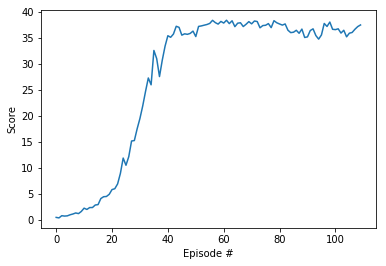

In [23]:
agent = Agent(state_size=33, action_size=4, num_agents=20, random_seed=10)

def ddpg(n_episodes=3000, max_t=1000):
    """ 
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
    """
    start_time = time.time()
    scores_deque = deque(maxlen=100)
    scores = [] 
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        agent.reset()
        agents_scores = np.zeros(num_agents)
        for t in range(max_t):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states
            agents_scores += rewards
            if any(dones):
                break 
        avg_agents_scores = np.mean(agents_scores)
        scores.append(avg_agents_scores)
        scores_deque.append(avg_agents_scores)
        avg_scores = np.mean(scores_deque)
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, avg_scores, avg_agents_scores), end="")
        if i_episode % 10 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, avg_scores))   
        if len(scores_deque) == 100 and avg_scores >= 30:
            end_time = time.time()
            total_time = end_time-start_time
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, avg_scores))
            print("Execution time in seconds: %s ",total_time)
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break

    return scores

scores = ddpg()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()